In [471]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import seaborn as sns 
import missingno as msno 
from utils import my_histogram, make_stacked_table, my_stacked_barplot

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report


import imblearn
from imblearn.over_sampling import SMOTE


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

# 1. Prepare the data

- Load all tables with extracted features.

In [12]:
train_outcome = pd.read_csv("../data/train_outcome.csv")
test_outcome = pd.read_csv("../data/test_outcome.csv")

df_train_demo = pd.read_csv("../data/df_train_demo.csv")
df_test_demo = pd.read_csv("../data/df_test_demo.csv")

df_train_measurment_time_info = pd.read_csv("../data/df_train_measurment_time_info.csv")
df_test_measurment_time_info = pd.read_csv("../data/df_test_measurment_time_info.csv")

df_train_measurement_grouped_stat = pd.read_csv("../data/df_train_measurement_grouped_stat.csv")
df_test_measurement_grouped_stat = pd.read_csv("../data/df_test_measurment_grouped_stat.csv")

- Merge all tables.

In [13]:
df_train_all = df_train_demo.merge(df_train_measurment_time_info, how = "left", on = "ID") \
                            .merge(df_train_measurement_grouped_stat, how = "left", on = "ID") \
                            .merge(train_outcome, how = "left", on = "ID")    

In [14]:
df_test_all = df_test_demo.merge(df_test_measurment_time_info, how = "left", on = "ID") \
                          .merge(df_test_measurement_grouped_stat, how = "left", on = "ID") \
                          .merge(test_outcome, how = "left", on = "ID")    

In [28]:
X_train = df_train_all.drop(["Outcome", "ID"], axis = 1)
y_train = df_train_all.Outcome

X_test = df_test_all.drop(["Outcome", "ID"], axis = 1)
y_test = df_test_all.Outcome

- Standardize the train and test data.

In [30]:
col_names = X_train.columns

In [29]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [31]:
X_train_std = pd.DataFrame(scaler.transform(X_train), columns = col_names)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns = col_names)

# 2. Baseline error

In [44]:
y_test.value_counts()

0    5623
1     867
Name: Outcome, dtype: int64

<AxesSubplot:xlabel='Outcome', ylabel='count'>

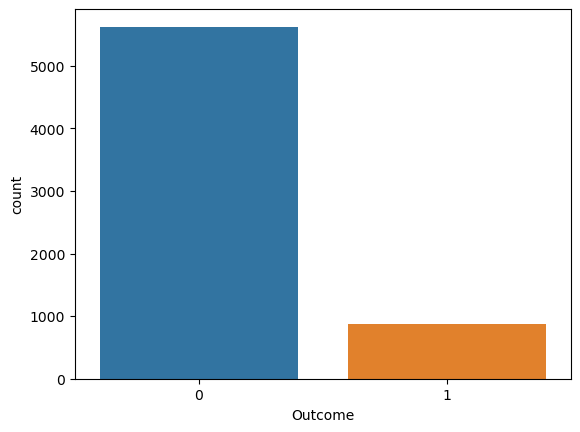

In [45]:
sns.countplot(x = y_test)

- Note that only 13% of patients have an Outcome = 1.
- That is, if we just predict all patient as Outcome = 0, we can achieve the 13% error, that is our baseline error.

- Let's choose models to tune the hyperparameters by comparing each model's error with the baseline error.

In [65]:
names = ["KNN", 
         "LDA", 
         "QDA", 
         "Naive Bayes",
         "Logistic regression",
         "Decesion tree", 
         "Random Forest",  
         "AdaBoost",
         "XGBoost",
         "Polynomial kernel SVM",
         "Radial kernel SVM",
         "GBM",
         "LightGBM"
        ]

classifiers = [
    KNeighborsClassifier(3),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(), 
    LogisticRegression(),
    DecisionTreeClassifier(random_state = 42),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    xgb.XGBClassifier(),
    SVC(kernel = "poly", probability = True),
    SVC(kernel = "rbf", probability = True),
    GradientBoostingClassifier(),
    lgb.LGBMClassifier()
    ]

In [71]:
result_accuracy = pd.DataFrame(names, columns = ["model_name"])

In [73]:
y_pred_dict = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_train_std, y_train)
    
    y_pred = clf.predict(X_test_std)
    y_pred_proba = clf.predict_proba(X_test_std)
    y_pred_dict[name] = y_pred
    
    error = np.mean(y_pred != y_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    result_accuracy.loc[result_accuracy.model_name == name, "Error"] = error
    result_accuracy.loc[result_accuracy.model_name == name, "BER"] = 1 - balanced_accuracy
    result_accuracy.loc[result_accuracy.model_name == name, "AUC"] = auc
    

In [74]:
result_accuracy

,model_name,Error,BER,AUC
0,KNN,0.092296,0.301056,0.764946
1,LDA,0.110169,0.362100,0.813528
2,QDA,0.155470,0.301905,0.799748
3,Naive Bayes,0.117565,0.295640,0.841536
4,Logistic regression,0.106317,0.354024,0.815425
5,Decesion tree,0.115408,0.236349,0.763651
6,Random Forest,0.066256,0.216764,0.911303
7,AdaBoost,0.072111,0.223069,0.888091
8,XGBoost,0.065485,0.203637,0.911156
9,Polynomial kernel SVM,0.089522,0.300431,0.825197


- Almost all models have smaller error than the baseline error 13%.
- Among the models, the error and the balanced error of LightGBM is the lowest at 6.3% and 20%.
- Also, Randomforest and XGBoost have small BER and high AUC values.
- So let's tune the hyperparameters of LightGBM, XGBoost, and RandomForest.

- Before tune the hyperparameters, let's check the confusion matrix.

Text(0.5, 1.0, 'Random Forest')

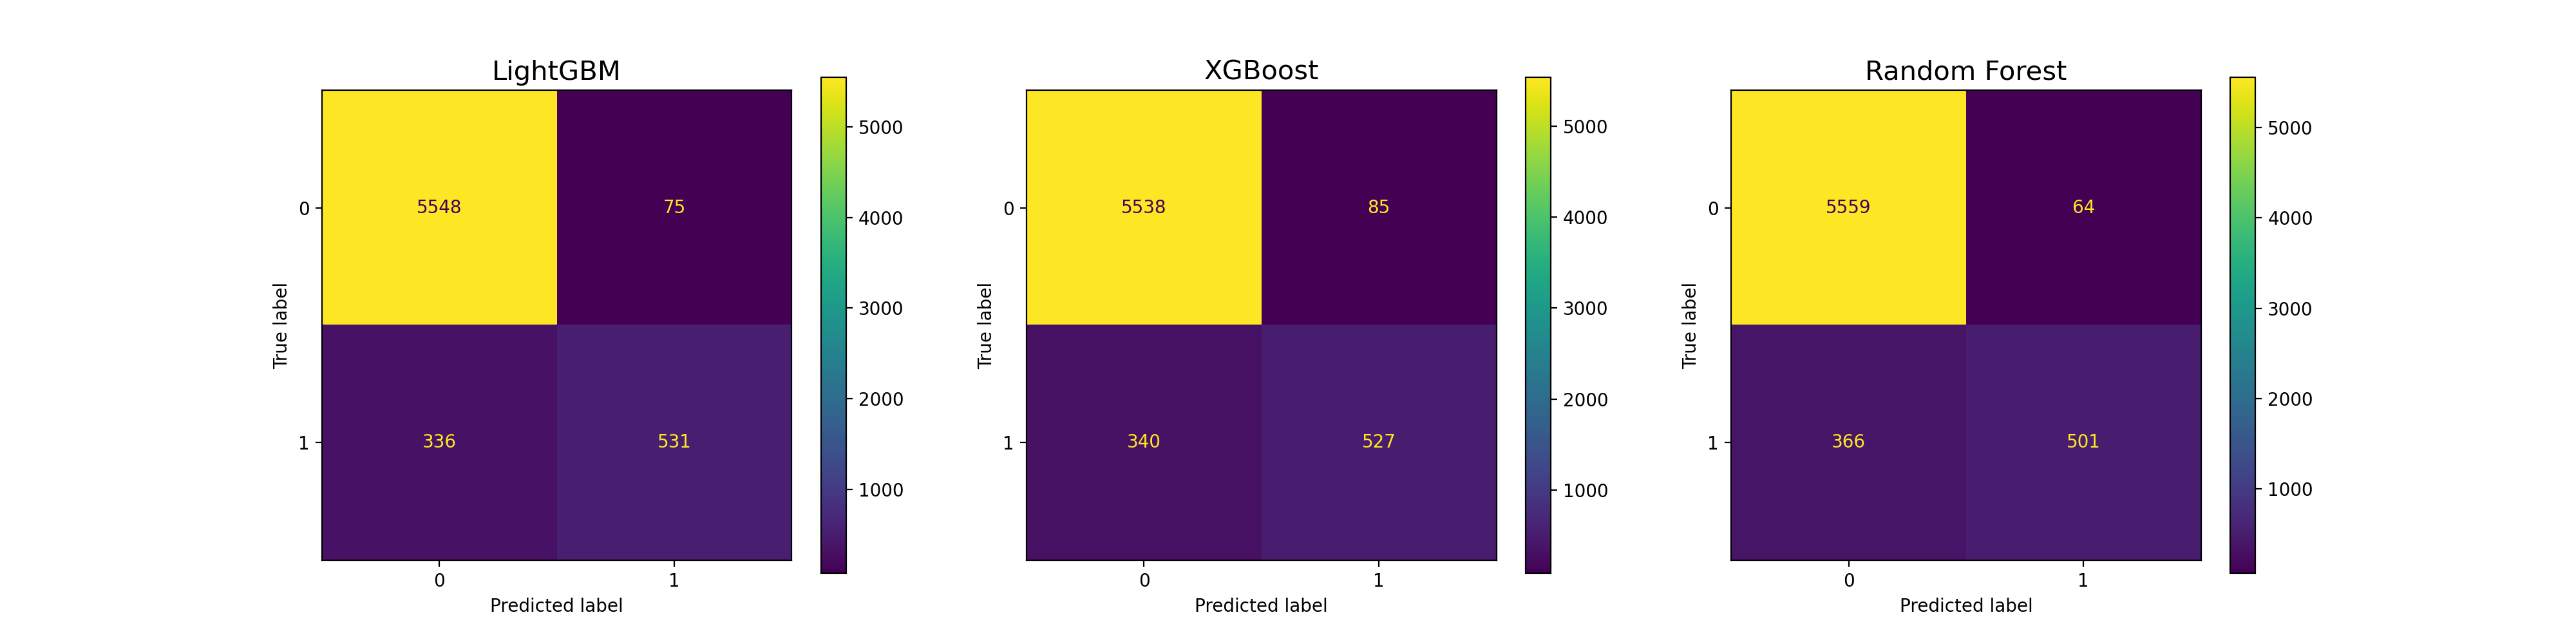

In [474]:
lgbm_cm = confusion_matrix(y_test, y_pred_dict["LightGBM"])
lgbm_cm_display = ConfusionMatrixDisplay(confusion_matrix = lgbm_cm, display_labels = clf.classes_)

xgboost_cm = confusion_matrix(y_test, y_pred_dict["XGBoost"])
xgboost_cm_display = ConfusionMatrixDisplay(confusion_matrix = xgboost_cm, display_labels = clf.classes_)

rf_cm = confusion_matrix(y_test, y_pred_dict["Random Forest"])
rf_cm_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm, display_labels = clf.classes_)

fig, axes = plt.subplots(1, 3, figsize = (20, 5))

lgbm_cm_display.plot(ax = axes[0])
axes[0].set_title("LightGBM", fontsize = 15)

xgboost_cm_display.plot(ax = axes[1])
axes[1].set_title("XGBoost", fontsize = 15)

rf_cm_display.plot(ax = axes[2])
axes[2].set_title("Random Forest", fontsize = 15)



- Models perform poorly at predicting Outcome = 1.

# 3. Hyperparameters tunning

- Now, let's tune the hyperparameter.
- There are two evaluation metrics. One is BER, and the other is AUC.
- First, tune the hyperparemeter of LightGBM, XGBoost, and RandomForest to maximize the AUC. 
- Among trained LightGBM, XGBoost, and RandomForest models with different hyperparameters, select top 15 models.
- From the best 15 models, get average of the scores.
- By using the mean score from 15 best models, calcualte the AUC.
- Then, let's find the best cutoff value for the mean score to achieve the minimum BER.   


## 3.1. LightGBM

- Candidate hyperparameters are as follow:
    - learning_rate: 0.01 ~ 0.3 
    - num_leaves: 20 ~ 3000 with step = 20
    - max_depth: 3 ~ 12 
    - min_data_in_leaf: 200 ~ 10000 with step = 100
    - max_bing: 200 ~ 300
    - lambda_l1: 0 ~ 100 with step = 5
    - lambda_l2: 0 ~ 100 with step = 5
    - min_gain_to_split: 0 ~ 15
    - bagging_fraction: 0.2 ~ 0.95 with step = 0.1
    - feature_fraction: 0.2 ~ 0.95 with step = 0.1

- There are two evaluation metrics. One is BER, and the other is AUC.
- First, tune the hyperparemeter to maximize the AUC. 
- Then, let's find the best cutoff value for score to achieve the minimum BER.  

In [322]:
def lgbm_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step = 20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step = 100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step = 5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step = 5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step = 0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step = 0.1
        ),
        "silent": 1,
        "verbose": -1
    }
    
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective = "binary", **param_grid, n_jobs = -1)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric = ["auc"],
            early_stopping_rounds = 100,
            callbacks=[
                LightGBMPruningCallback(trial, "auc")
            ],  # Add a pruning callback
            verbose = -1
        )
        preds_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, preds_proba[:, 1])
        cv_scores[idx] = auc

    return np.mean(cv_scores)

In [ ]:
lgbm_study = optuna.create_study(direction = "maximize", study_name = "LGBM Classifier")
func = lambda trial: lgbm_objective(trial, X_train_std, y_train)
lgbm_study.optimize(func, n_trials = 100)

In [324]:
lgbm_trials_history = lgbm_study.get_trials()

trial_list = []
hyperparameters_list = []
auc_list = []

for i in range(len(lgbm_trials_history)):
    trial_list.append(lgbm_trials_history[i].number) 
    hyperparameters_list.append(lgbm_trials_history[i].params)
    auc_list.append(lgbm_trials_history[i].values[0])
    
lgbm_auc_history = pd.DataFrame({"trial": trial_list, "auc": auc_list, "params": hyperparameters_list})

In [325]:
lgbm_auc_history.sort_values("auc", ascending = False)

,trial,auc,params
85,85,0.943124,"{'n_estimators': 10000, 'learning_rate': 0.145..."
55,55,0.940711,"{'n_estimators': 10000, 'learning_rate': 0.120..."
67,67,0.940047,"{'n_estimators': 10000, 'learning_rate': 0.132..."
80,80,0.939630,"{'n_estimators': 10000, 'learning_rate': 0.172..."
39,39,0.939020,"{'n_estimators': 10000, 'learning_rate': 0.136..."
...,...,...,...
10,10,0.500000,"{'n_estimators': 10000, 'learning_rate': 0.197..."
8,8,0.500000,"{'n_estimators': 10000, 'learning_rate': 0.259..."
4,4,0.500000,"{'n_estimators': 10000, 'learning_rate': 0.253..."
2,2,0.500000,"{'n_estimators': 10000, 'learning_rate': 0.054..."


## 3.2. XGBoost

- Candidate hyperparameters are as follow:
    - n_estimators: 100, 300, 500, 1000
    - learning_rate: 1e-8 ~ 1 
    - max_depth: 3 ~ 20 
    - lambda: 1e-8 ~ 1 
    - alpha: 1e-8 ~ 1 
    - gamma: 1e-8 ~ 1 
    - subsample: 0.01 ~ 0.3 with step = 0.02
    - colsample_bytree: 0.4 ~ 1.0 with step = 0.1
    - colsample_bylevel: 0.4 ~ 1.0 with step = 0.1

In [328]:
def xgboost_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 300, 500, 1000]),
        "eta": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "gamma": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.01, 0.3, step = 0.02),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0, step = 0.1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.4, 1.0, step = 0.1),
        "verbosity": 0
    }

    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = xgb.XGBClassifier(objective = "binary:logistic", **param_grid, n_jobs = -1)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric = ["auc"],
            early_stopping_rounds = 100,
            callbacks=[
                XGBoostPruningCallback(trial, "validation_0-auc")
            ],  # Add a pruning callback
        )
        
        preds_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, preds_proba[:, 1])
        cv_scores[idx] = auc

    return np.mean(cv_scores)

In [ ]:
xgboost_study = optuna.create_study(direction = "maximize", study_name = "XGBoost Classifier")
func = lambda trial: xgboost_objective(trial, X_train_std, y_train)
xgboost_study.optimize(func, n_trials = 100)

In [330]:
xgboost_trials_history = xgboost_study.get_trials()

trial_list = []
hyperparameters_list = []
auc_list = []

for i in range(len(xgboost_trials_history)):
    trial_list.append(xgboost_trials_history[i].number) 
    hyperparameters_list.append(xgboost_trials_history[i].params)
    auc_list.append(xgboost_trials_history[i].values[0])
    
xgboost_auc_history = pd.DataFrame({"trial": trial_list, "auc": auc_list, "params": hyperparameters_list})

In [331]:
xgboost_auc_history.sort_values("auc", ascending = False)

,trial,auc,params
25,25,0.925149,"{'n_estimators': 500, 'alpha': 9.4863506092290..."
41,41,0.924905,"{'n_estimators': 500, 'alpha': 3.4232784401779..."
34,34,0.919624,"{'n_estimators': 500, 'alpha': 2.2767849840122..."
29,29,0.917429,"{'n_estimators': 300, 'alpha': 2.0219184532052..."
88,88,0.916726,"{'n_estimators': 300, 'alpha': 2.7510681730152..."
...,...,...,...
80,80,0.500000,"{'n_estimators': 500, 'alpha': 2.4663181451532..."
21,21,0.500000,"{'n_estimators': 500, 'alpha': 1.0123144391688..."
9,9,0.500000,"{'n_estimators': 100, 'alpha': 4.2479074365499..."
57,57,0.500000,"{'n_estimators': 100, 'alpha': 3.2214812056006..."


## 3.3. RandomForest

- Candidate hyperparameters are as follow:
    - n_estimators: 100, 300, 500, 1000
    - learning_rate: 1e-8 ~ 1 
    - max_depth: 3 ~ 20 
    - max_features: auto, sqrt, log2
    - min_samples_leaf: 1 ~ 10
    - min_samples_split: 2 ~ 10

In [350]:
def rf_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 300, 500, 1000]),
        "max_depth": trial.suggest_int("max_depth", 3, 20, step = 2),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    }
    
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    
    model = RandomForestClassifier(**param_grid, n_jobs = -1)
    cv_results = cross_validate(model, X, y, cv = cv, scoring = "roc_auc", n_jobs = -1)


    return np.mean(cv_results['test_score'])

In [ ]:
rf_study = optuna.create_study(direction = "maximize", study_name = "RandomForest Classifier")
func = lambda trial: rf_objective(trial, X_train_std, y_train)
rf_study.optimize(func, n_trials = 20)

In [353]:
rf_trials_history = rf_study.get_trials()

trial_list = []
hyperparameters_list = []
auc_list = []

for i in range(len(rf_trials_history)):
    trial_list.append(rf_trials_history[i].number) 
    hyperparameters_list.append(rf_trials_history[i].params)
    auc_list.append(rf_trials_history[i].values[0])
    
rf_auc_history = pd.DataFrame({"trial": trial_list, "auc": auc_list, "params": hyperparameters_list})

In [354]:
rf_auc_history.sort_values("auc", ascending = False)

,trial,auc,params
13,13,0.921056,"{'n_estimators': 500, 'max_depth': 15, 'max_fe..."
15,15,0.920583,"{'n_estimators': 300, 'max_depth': 15, 'max_fe..."
19,19,0.920497,"{'n_estimators': 300, 'max_depth': 15, 'max_fe..."
14,14,0.920441,"{'n_estimators': 500, 'max_depth': 15, 'max_fe..."
2,2,0.920377,"{'n_estimators': 500, 'max_depth': 17, 'max_fe..."
18,18,0.920144,"{'n_estimators': 300, 'max_depth': 15, 'max_fe..."
11,11,0.920087,"{'n_estimators': 500, 'max_depth': 13, 'max_fe..."
12,12,0.919690,"{'n_estimators': 500, 'max_depth': 13, 'max_fe..."
10,10,0.919352,"{'n_estimators': 500, 'max_depth': 13, 'max_fe..."
9,9,0.918802,"{'n_estimators': 100, 'max_depth': 19, 'max_fe..."


## 3.4. Choose the best 15 models

- Among all trained models, let's choose the best 15 models based on the AUC value.

In [355]:
lgbm_auc_history["model"] = "lgbm"
xgboost_auc_history["model"] = "xgboost"
rf_auc_history["model"] = "rf"

all_auc_history = pd.concat([lgbm_auc_history, xgboost_auc_history, rf_auc_history])

In [362]:
best_15_models = all_auc_history.sort_values("auc", ascending = False).head(15)
best_15_models

,trial,auc,params,model
85,85,0.943124,"{'n_estimators': 10000, 'learning_rate': 0.145...",lgbm
55,55,0.940711,"{'n_estimators': 10000, 'learning_rate': 0.120...",lgbm
67,67,0.940047,"{'n_estimators': 10000, 'learning_rate': 0.132...",lgbm
80,80,0.939630,"{'n_estimators': 10000, 'learning_rate': 0.172...",lgbm
39,39,0.939020,"{'n_estimators': 10000, 'learning_rate': 0.136...",lgbm
60,60,0.938714,"{'n_estimators': 10000, 'learning_rate': 0.127...",lgbm
87,87,0.930233,"{'n_estimators': 10000, 'learning_rate': 0.110...",lgbm
31,31,0.929903,"{'n_estimators': 10000, 'learning_rate': 0.120...",lgbm
30,30,0.928990,"{'n_estimators': 10000, 'learning_rate': 0.129...",lgbm
61,61,0.928796,"{'n_estimators': 10000, 'learning_rate': 0.114...",lgbm


# 4. Select cut-off score

- Let's find the best cut-off score for classifying binary outcome class.
- Split the train set into train and validation set and train the model by using the train set with the parameters found in the hyperparamter tuning step. Then, we can define a set of thresholds and then evaluate predicted probabilities under each in order to find and select the optimal threshold by using the validation set.

- First, split the train set into the train and validation set.
- Since our data is imbalanced, use the stratified sampling with the ratio = 0.2.

In [367]:
X_y_train = pd.concat([X_train_std, pd.DataFrame({"Outcome": y_train})], axis = 1)

In [369]:
X_y_train_train = X_y_train.groupby("Outcome", group_keys = False).apply(lambda x: x.sample(frac = 0.8))
X_y_train_train.Outcome.value_counts()

0    10463
1     1652
Name: Outcome, dtype: int64

In [370]:
X_y_train_valid = X_y_train[~X_y_train.index.isin(X_y_train_train.index)]
X_y_train_valid.Outcome.value_counts()

0    2616
1     413
Name: Outcome, dtype: int64

In [ ]:
X_train_train = X_y_train_train.drop("Outcome", axis = 1)
y_train_train = X_y_train_train.Outcome

X_train_valid = X_y_train_valid.drop("Outcome", axis = 1)
y_train_valid = X_y_train_valid.Outcome

- We splited the train set into train and validation set
    - train set: 12,115
        - Outcome = 0: 10,463
        - Outcome = 1: 1,652
    - validation set: 3,029
        - Outcome = 0: 2,619
        - Outcome = 1: 413
        

- Now calculate the scores from the best 15 models and get the average scores, which will be used to calcualte the AUC and BER.

In [ ]:
best_15_models_proba = []

for i in range(best_15_models.shape[0]):
    params = best_15_models.iloc[i].params 
    model_name = best_15_models.iloc[i].model 
    
    if model_name == "lgbm": model = lgb.LGBMClassifier(**params)
    elif model_name == "xgboost": model = xgb.XGBClassifier(**params)
    elif model_name == "rf": model = RandomForestClassifier(**params)
    
    model.fit(X_train_train, y_train_train)
    y_pred_proba = model.predict_proba(X_train_valid)
    best_15_models_proba.append(y_pred_proba)
    

In [398]:
best_15_avg_prob = best_15_models_proba[0]

for i in range(1, 15):
    best_15_avg_prob = best_15_avg_prob + best_15_models_proba[i]

best_15_avg_prob = best_15_avg_prob/15

In [399]:
best_15_avg_prob

array([[0.98045849, 0.01954151],
       [0.97563099, 0.02436901],
       [0.95791448, 0.04208552],
       ...,
       [0.04403311, 0.95596689],
       [0.769854  , 0.230146  ],
       [0.98536498, 0.01463502]])

In [417]:
thresholds = np.arange(0.0, 1.0, 0.0001)
ber_list = np.zeros(shape = (len(thresholds)))


In [418]:
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred = (best_15_avg_prob[:, 1] > elem).astype("int")
    
    # Calculate the BER
    ber_list[index] = 1 - balanced_accuracy_score(y_train_valid, y_pred)

In [421]:
# Find the optimal threshold
index = np.argmin(ber_list)
threshold_Opt = round(thresholds[index], ndigits = 4)
ber_Opt = round(ber_list[index], ndigits = 4)
print('Best Threshold: {} with BER: {}'.format(threshold_Opt, ber_Opt))

Best Threshold: 0.1867 with BER: 0.126


Text(0.1067, 0.176, 'Optimal threshold \n for Outcome = 1: 0.1867')

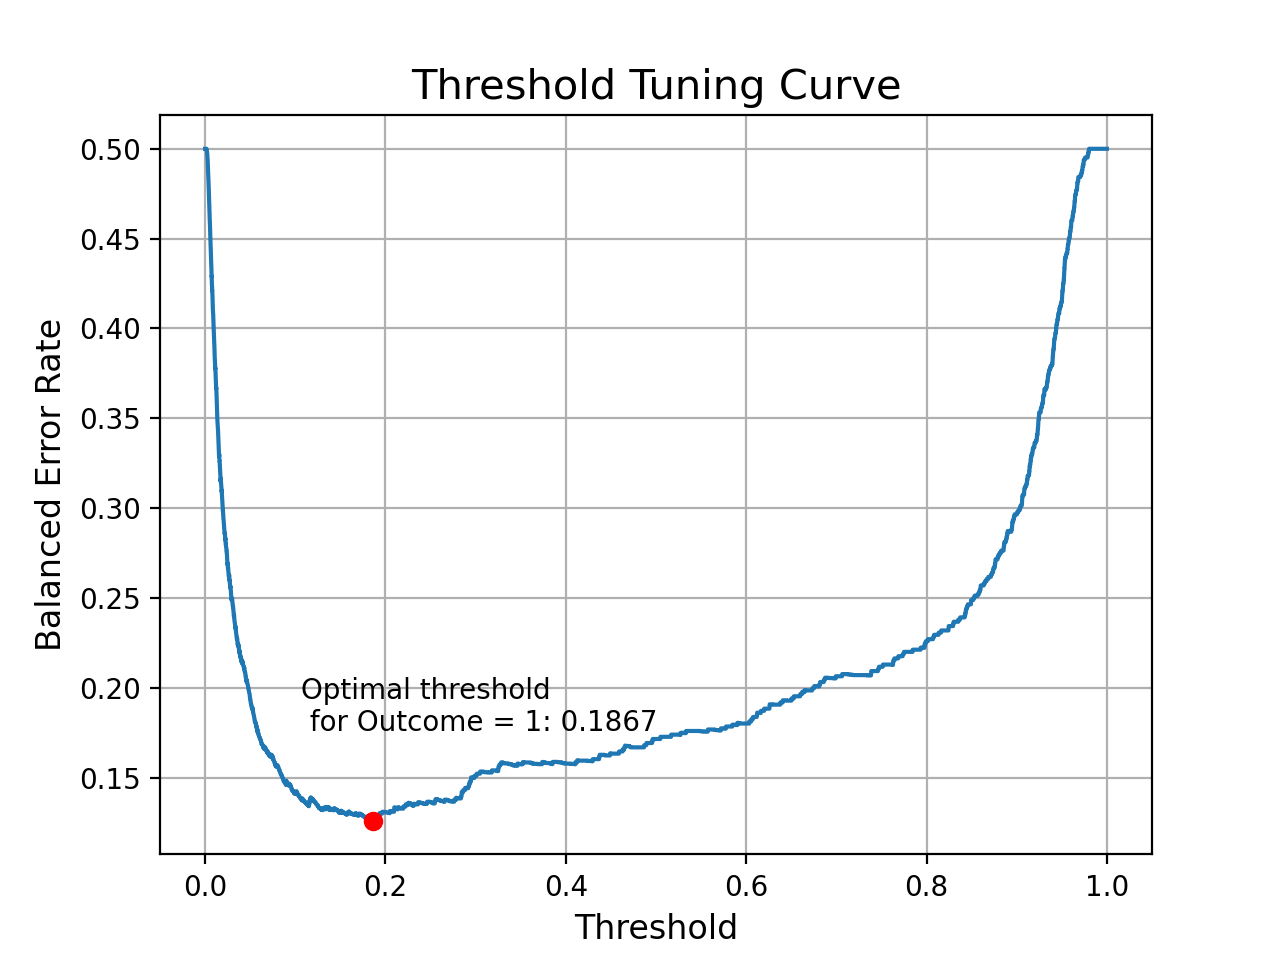

In [445]:
plt.grid()
sns.lineplot(x = thresholds, y = ber_list)
plt.xlabel("Threshold", fontsize = 12)
plt.ylabel("Balanced Error Rate", fontsize = 12)
plt.title("Threshold Tuning Curve", fontsize = 15)

plt.plot(threshold_Opt, ber_Opt, "ro")
plt.text(x = threshold_Opt - 0.08, y = ber_Opt + 0.05, s = f'Optimal threshold \n for Outcome = 1: {threshold_Opt}')

- When we set 0.1867 as the cut-off score for the Outcome = 1, then we can achieve the best BER 0.126 on the validation set.

# 5. Calculate the BER and AUC

- Now let's calculate the BER and AUC on the test data.

In [ ]:
best_15_models_proba_test = []

for i in range(best_15_models.shape[0]):
    params = best_15_models.iloc[i].params 
    model_name = best_15_models.iloc[i].model 
    
    if model_name == "lgbm": model = lgb.LGBMClassifier(**params)
    elif model_name == "xgboost": model = xgb.XGBClassifier(**params)
    elif model_name == "rf": model = RandomForestClassifier(**params)
    
    model.fit(X_train_std, y_train)
    y_pred_proba = model.predict_proba(X_test_std)
    best_15_models_proba_test.append(y_pred_proba)
    

In [462]:
best_15_avg_prob_test = best_15_models_proba_test[0]

for i in range(1, 15):
    best_15_avg_prob_test = best_15_avg_prob_test + best_15_models_proba_test[i]

best_15_avg_prob_test = best_15_avg_prob_test / 15

In [464]:
best_15_avg_prob_test

array([[0.98290209, 0.01709791],
       [0.89942117, 0.10057883],
       [0.97529847, 0.02470153],
       ...,
       [0.98090421, 0.01909579],
       [0.98463654, 0.01536346],
       [0.96578141, 0.03421859]])

In [465]:
y_pred = (best_15_avg_prob_test[:, 1] > threshold_Opt).astype("int")

test_ber = 1 - balanced_accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, best_15_avg_prob_test[:, 1])

In [466]:
print("Best AUC before tuning the parameters: ", result_accuracy.AUC.max())
print("AUC after tuning the parameters: ", test_auc)

Best AUC before tuning the parameters:  0.9169488636328671
AUC after tuning the parameters:  0.9158752536593299


In [468]:
print("Best BER before tuning the parameters: ", result_accuracy.BER.min())
print("BER after tuning the parameters: ", test_ber)

Best BER before tuning the parameters:  0.200440664177713
BER after tuning the parameters:  0.16305466857266282


- AUC is almost the same after tuning, but BER significantly decreased after tuning.

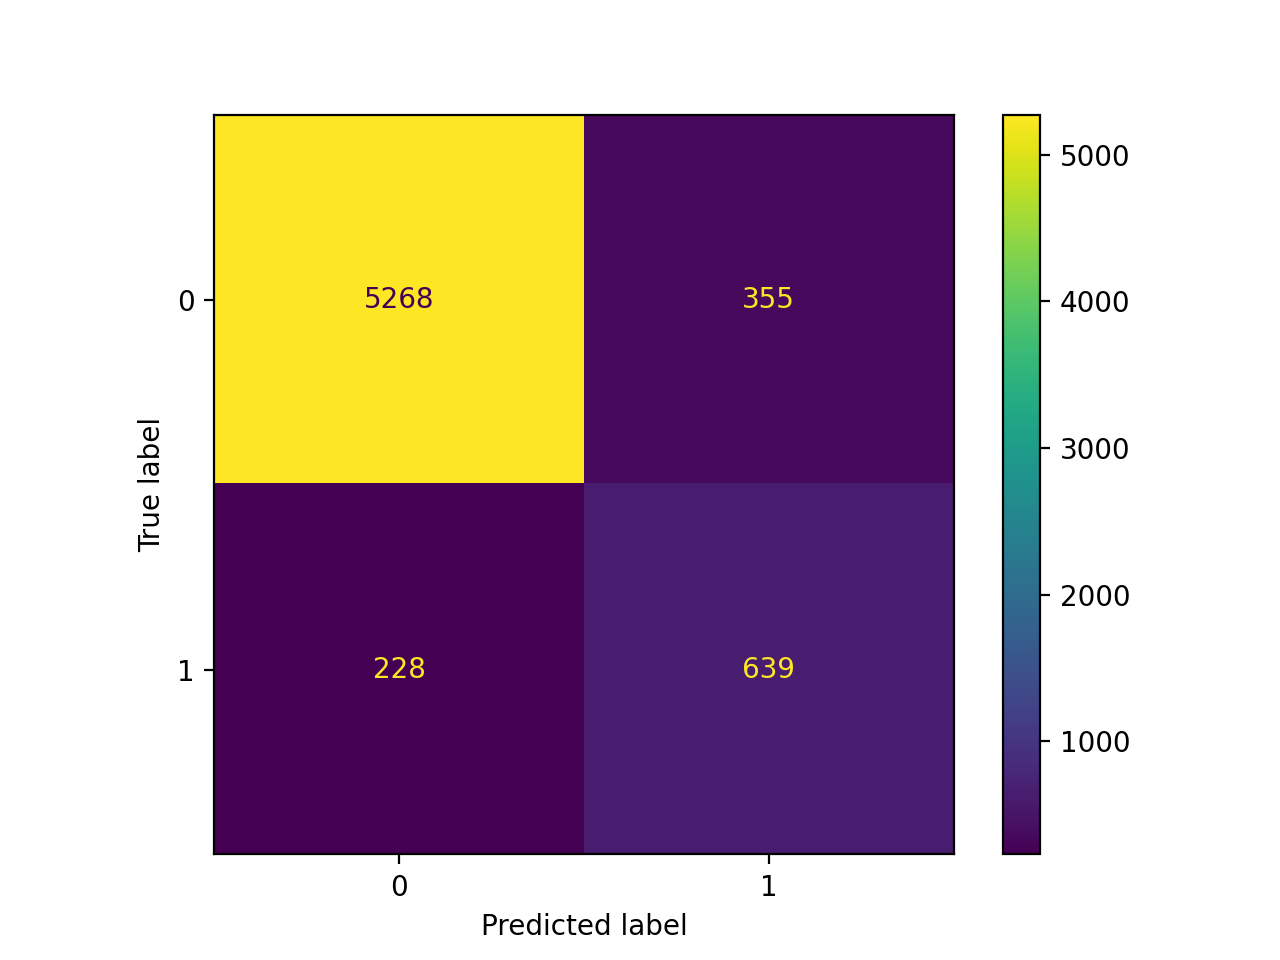

In [470]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)
cm_display.plot();    

In [472]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      5623
           1       0.64      0.74      0.69       867

    accuracy                           0.91      6490
   macro avg       0.80      0.84      0.82      6490
weighted avg       0.92      0.91      0.91      6490

